# Hybrid methods

## Feature shuffling
Shuffle the values of each feature, one feature at a time, and measure how much the permutation (or shuffling of its values) decreases the `accuracy`, or the `roc_auc`, or the `mse` of the machine learning model (or any other performance metric!). If the variables are important, a random permutation of their values will dramatically decrease any of these metrics. Contrarily, the permutation or shuffling of values should have little to no effect on the model performance metric we are assessing.

The procedure goes more or less like this:

- Build a machine learning model and store its performance metrics.
- Shuffle 1 feature, and make a new prediction using the previous model.
- Determine the performance of this prediction.
- Determine the change in the performance of the prediction with the shuffled feature compared to the original one.
- Repeat for each feature.

To select features, we chose those that induced a decrease in model performance beyond an arbitrarily set threshold.

**Note**: In fact, the importance of the features is determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features.

In [84]:
from feature_engine.selection import SelectByShuffling

rf = RandomForestClassifier( n_estimators=50, max_depth=2, n_jobs=4)

sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=rf, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=3, # cross validation
    random_state=1 # seed
)

sel.fit(X_train, y_train)

SelectByShuffling(estimator=RandomForestClassifier(max_depth=2, n_estimators=50,
                                                   n_jobs=4),
                  random_state=1, threshold=0)

In [85]:
# performance of model trained with all features
sel.initial_model_performance_

0.6884136580496532

<AxesSubplot: >

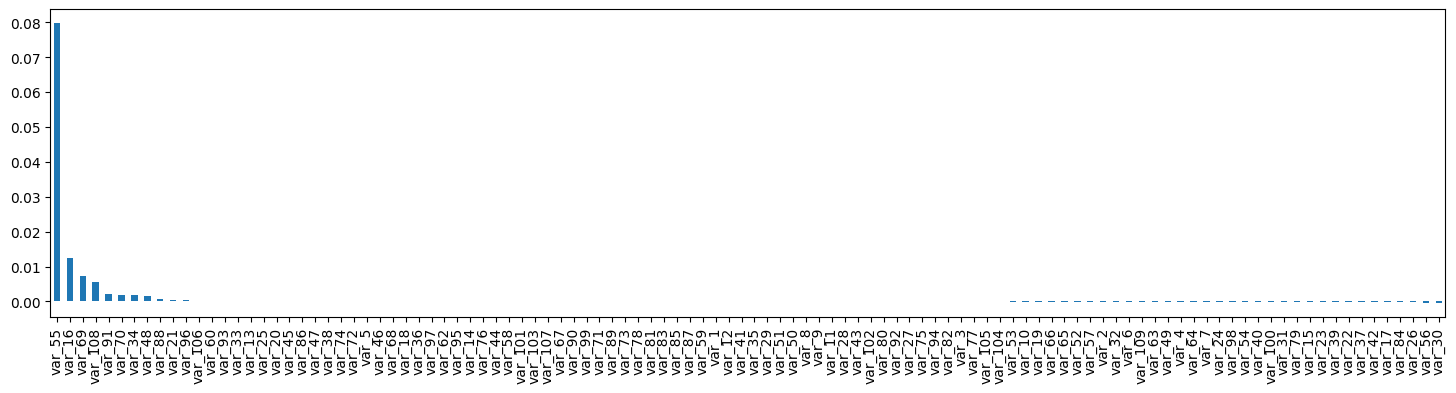

In [88]:
# drop in performance caused by shuffling the feature
sel.performance_drifts_

# bar plot of the performance drops
pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(18,4))

In [89]:
# remove features

X_train_sl = sel.transform(X_train)
X_test_sl = sel.transform(X_test)

X_train_sl.shape, X_test_sl.shape

((35000, 8), (15000, 8))

In [90]:
X_train_sl.columns

Index(['var_16', 'var_34', 'var_48', 'var_55', 'var_69', 'var_70', 'var_91',
       'var_108'],
      dtype='object')

## Recursive feature elimination

**This method consists of the following steps:**

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.

2) Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

3) Calculate a performance metric of choice: roc-auc, mse, rmse, accuracy, etc.

4) If the metric decreases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

5) Repeat steps 2-4 until all features have been evaluated.

**This is a hybrid method because:**

- it derives the importance derived from the machine learning algorithm, like embedded methods

- it builds several machine learning models, like wrapper methods.

**Advantages:**
- This method is faster than wrapper methods and often better than embedded methods. In practice, it works extremely well.

**Note:**
- The minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop, the more features will be selected, and vice versa.

In [91]:
from feature_engine.selection import RecursiveFeatureElimination
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

# the ML model for which we want to select features
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'roc_auc', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=2, # cross-validation
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train, y_train)

RecursiveFeatureElimination(cv=2,
                            estimator=GradientBoostingClassifier(max_depth=2,
                                                                 n_estimators=10,
                                                                 random_state=10),
                            threshold=0.0005)

In [94]:
# select features

X_train_sl = sel.transform(X_train)
X_test_sl = sel.transform(X_test)

X_train_sl.shape, X_test_sl.shape

((35000, 2), (15000, 2))

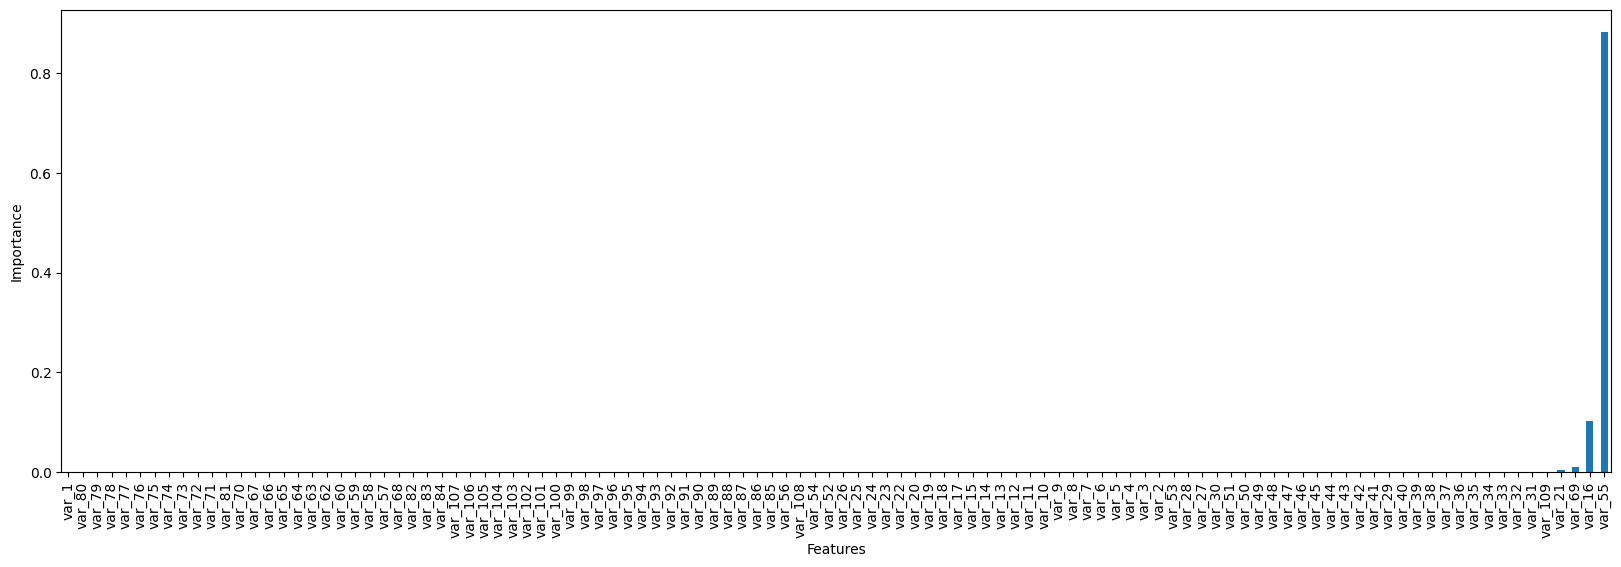

In [92]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

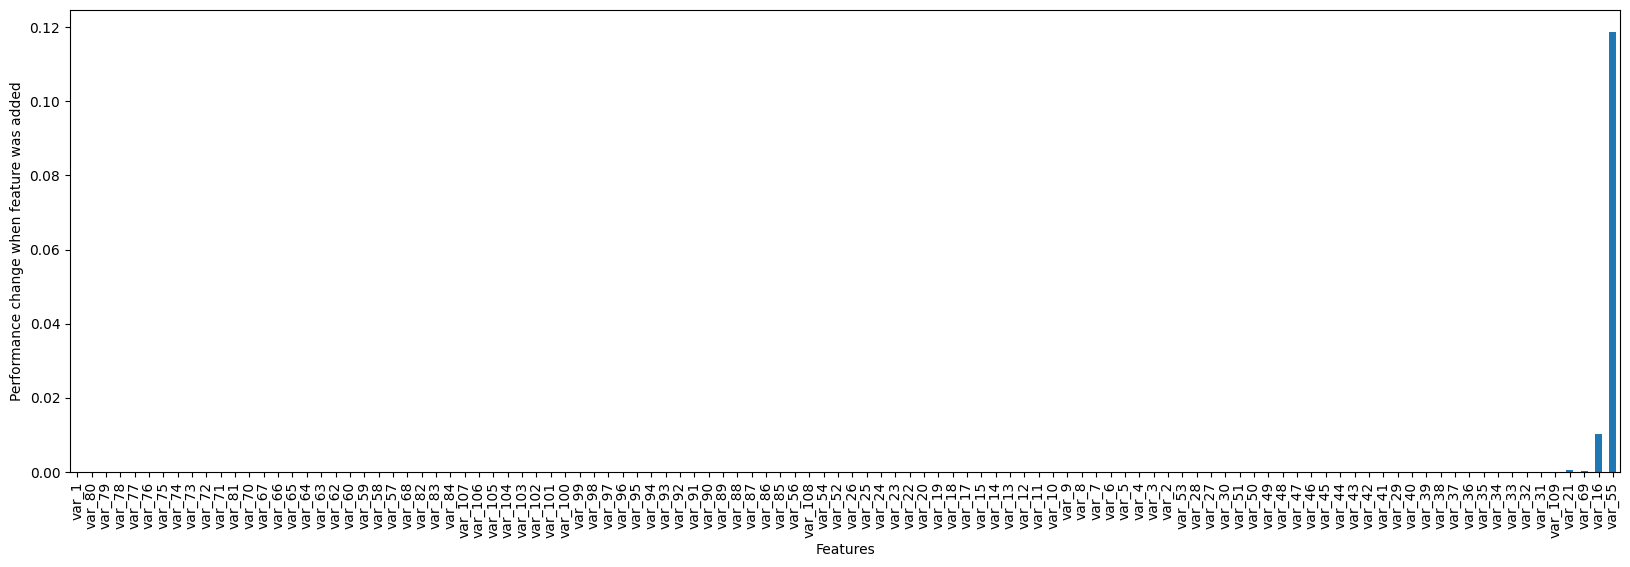

In [93]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [95]:
# check performance
def get_scoring(model, X_train, y_train, X_test, y_test , score_func):
    # fit the model with the selected features
    model.fit(X_train, y_train)

    # make predictions
    y_pred_test = model.predict_proba(X_test)[:, 1]

    # calculate roc-auc
    score = score_func(y_test, y_pred_test)
    print('Test selected features score = %f' % (score))
    
get_scoring(model, X_train, y_train, X_test, y_test , roc_auc_score)
get_scoring(model, X_train_sl, y_train, X_test_sl, y_test , roc_auc_score)

Test selected features score = 0.690742
Test selected features score = 0.688795


## Recursive feature addition

**This method consists of the following steps:**

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or coefficients from linear models.

2) Build a machine learning model with only 1 feature, the most important one, and calculate the model metric for performance.

3) Add one feature -the most important- and build a machine learning algorithm utilising the added and any feature from previous rounds.

4) Calculate a performance metric of your choice: roc-auc, mse, rmse, accuracy, etc.

5) If the metric increases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

6) Repeat steps 2-5 until all features have been evaluated.


**This is a hybrid method because:**
- it derives the importance derived from the machine learning algorithm, like embedded methods
- it builds several machine learning models, like wrapper methods.

**Advantages:**
- This method is faster than wrapper methods and often better than embedded methods. In practice it works extremely well. 

**Note:**
- The minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop the more features will be selected, and vice versa.

In [ ]:
from feature_engine.selection import RecursiveFeatureAddition

# the ML model for which we want to select features
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

# Setup the RFA selector
rfa = RecursiveFeatureAddition(
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='roc_auc',  # the metric we want to evalute
    threshold=0.0001,  # the minimum performance increase needed to select a feature
    cv=2,  # cross-validation
)

rfa.fit(X_train, y_train)